## Load Packages

In [1]:
suppressPackageStartupMessages({ 
    library(data.table) 
    library(dplyr) 
    library(ggplot2) 
    library(SingleCellExperiment)
    library(dplyr)
    library(celldex)
    library(SingleR)
    library(RColorBrewer)
    library(scater) 
    library(StabMap) 
    library(scran) 
    library(harmony) 
    library(patchwork)
    library(Seurat)
    library(plotly)
    library(pheatmap)
    library(batchelor)
    library(ggpubr)
    library(cowplot)
    library(viridis)
    library(patchwork)
    library(Cairo)
    library(grid)
    library(png)
    library(reshape2)  # Or use tidyr
    library(ggplot2)
    library(gridExtra)
    library(patchwork)
    library(grid)
    library(Cairo)
    library(png)
})

## Data Locations

In [2]:
##### Load in Seurat Objects for post QC analyses #####

io = list()
io$main = "/rds/project/rds-SDzz0CATGms/users/ltgh2" # this is the main directory

# Set the working directory
setwd(io$main)

# Load in the refined annotations
io$refined_annotations = file.path(io$main, "projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/outputs/FINAL_REFINED_ANNOTATIONS_REVISIONS.Rds") 

# Load in the pre_QC seqFISH OBJECT
io$seqFISH_preQC = file.path(io$main, "projects/03_seqFISH_FINAL/code/seqFISH_integration/processed/seqFISH_within_and_across_dataset_integration_without_neighbour_features_E6_7_8.Rds") 
io$seqFISH_preQC_meta = file.path(io$main, "projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/outputs/Figure_1_seurats/seqFISH_preQC_metadata.rds") 

# Load in the post_QC seqFISH OBJECT

io$seqFISH_postQC = file.path(io$main, "projects/03_seqFISH_FINAL/code/seqFISH_integration/processed/seqFISH_after_QC_filtering_within_and_across_dataset_integration_without_neighbour_features_E6_7_8.Rds") 
io$seqFISH_postQC_UMAP = file.path(io$main, "projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/outputs/Figure_1_seurats/postQC_seqFISH_umap_dimreduced.rds") 
io$seqFISH_postQC_pca = file.path(io$main, "projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/outputs/Figure_1_seurats/postQC_seqFISH_pca_dimreduced.rds")


## Load in the seqFISH Imputed Gene Expression
io$seqFISH_imputed_logcounts_e6 = file.path(io$main, 
                              "projects/03_seqFISH_FINAL/code/stabmap_imputation/output/seqFISH_e6_postQC_imputed_RNA.Rds")

io$seqFISH_imputed_logcounts_e7 = file.path(io$main, 
                              "projects/03_seqFISH_FINAL/code/stabmap_imputation/output/seqFISH_e7_postQC_imputed_RNA.Rds")

io$seqFISH_imputed_logcounts_e8_1 = file.path(io$main, 
                              "projects/03_seqFISH_FINAL/code/stabmap_imputation/output/seqFISH_e8_embryo1_postQC_imputed_RNA.Rds")

io$seqFISH_imputed_logcounts_e8_2 = file.path(io$main, 
                              "projects/03_seqFISH_FINAL/code/stabmap_imputation/output/seqFISH_e8_embryo2_postQC_imputed_RNA.Rds")

io$seqFISH_imputed_logcounts_e8_3 = file.path(io$main, 
                              "projects/03_seqFISH_FINAL/code/stabmap_imputation/output/seqFISH_e8_embryo3_postQC_imputed_RNA.Rds")

## Load in PreQC Seurat

In [3]:
# Load in the seqFISH object_postQC
seqFISH_preQC = readRDS(io$seqFISH_preQC)
seqFISH_preQC_meta = readRDS(io$seqFISH_preQC_meta)

seqFISH_preQC <- seqFISH_preQC[,seqFISH_preQC@meta.data$Estage %in% c("E6.5", "E7.5")]

# Add the MetaData to the Object
seqFISH_preQC <- AddMetaData(seqFISH_preQC, metadata = seqFISH_preQC_meta)

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from shila_umap_ to shilaumap_”


## Load in PostQC Seurat

In [4]:
# Load in the seqFISH object_postQC
seqFISH_postQC = readRDS(io$seqFISH_postQC)
seqFISH_postQC_UMAP = readRDS(io$seqFISH_postQC_UMAP)
seqFISH_postQC_pca = readRDS(io$seqFISH_postQC_pca)

# Load in the imputed gene expression 
seqFISH_imputed_logcounts_e6 = readRDS(io$seqFISH_imputed_logcounts_e6)
seqFISH_imputed_logcounts_e7 = readRDS(io$seqFISH_imputed_logcounts_e7)
seqFISH_imputed_logcounts_e8_1 = readRDS(io$seqFISH_imputed_logcounts_e8_1)
seqFISH_imputed_logcounts_e8_2 = readRDS(io$seqFISH_imputed_logcounts_e8_2)
seqFISH_imputed_logcounts_e8_3 = readRDS(io$seqFISH_imputed_logcounts_e8_3)

# Create a combined matrix of gene expression across all time points
imputed_expression <- cbind(seqFISH_imputed_logcounts_e6$scRNA.RNA, 
                            seqFISH_imputed_logcounts_e7$scRNA.RNA, 
                            seqFISH_imputed_logcounts_e8_1$scRNA.RNA, 
                            seqFISH_imputed_logcounts_e8_2$scRNA.RNA, 
                            seqFISH_imputed_logcounts_e8_3$scRNA.RNA)

# Creat a new assay object to store imputed data
imp <- CreateAssayObject(data = imputed_expression)

# add this assay to the previously created Seurat object
seqFISH_postQC[["imputed"]] <- imp

# only keep the early embryos 
seqFISH_postQC <- seqFISH_postQC[,seqFISH_postQC@meta.data$Estage %in% c("E6.5", "E7.5")]

# add the PCs and the UMAP coordinates
seqFISH_postQC[["seqFISH_postQC_UMAP"]] <- seqFISH_postQC_UMAP
seqFISH_postQC[["seqFISH_postQC_pca"]] <- seqFISH_postQC_pca

# Add the MetaData to the Object
seqFISH_postQC <- AddMetaData(seqFISH_postQC, metadata = seqFISH_preQC_meta)

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from shila_umap_ to shilaumap_”
Warning message:
“Cannot add objects with duplicate keys (offending key: UMAP_), setting key to 'seqfish_postqc_umap_'”
Warning message:
“Cannot add objects with duplicate keys (offending key: PC_), setting key to 'seqfish_postqc_pca_'”


## Load in the Refined Annotations

In [5]:
# Load in the refined_annotations
refined_annotations = readRDS(io$refined_annotations)

In [6]:
colnames(refined_annotations)

[1] "cell_ID"                                             
 [2] "orig.ident"                                          
 [3] "nCount_RNA"                                          
 [4] "nFeature_RNA"                                        
 [5] "seqFISH_celltype"                                    
 [6] "extended_atlas_celltype"                             
 [7] "AP"                                                  
 [8] "DV"                                                  
 [9] "dataset"                                             
[10] "cluster"                                             
[11] "subcluster"                                          
[12] "cluster_subcluster"                                  
[13] "stage"                                               
[14] "anatomy"                                             
[15] "UMAP_1"                                              
[16] "UMAP_2"                                              
[17] "celltype_PijuanSala2019"                             
[18] "majority_seqFISH_celltype"                           
[19] "majority_seqFISH_celltype_proportion"                
[20] "majority_extended_atlas_celltype"                    
[21] "majority_extended_atlas_celltype_proportion"         
[22] "majority_celltype_PijuanSala2019_celltype"           
[23] "majority_celltype_PijuanSala2019_celltype_proportion"
[24] "stage_transfer"                                      
[25] "poor_stage_alignment"                                
[26] "proportion_seqFISH_cells_per_subcluster"             
[27] "joint_clusters_pass_QC"                              
[28] "stage_alignment_pass_QC"                             
[29] "passed_QC"                                           
[30] "refined_annotation"                                  
[31] "embryo"

In [7]:
refined_annotations_ss <- subset(refined_annotations, select = c(refined_annotation, celltype_PijuanSala2019, extended_atlas_celltype))

In [8]:
seqFISH_postQC <- AddMetaData(seqFISH_postQC, metadata = refined_annotations_ss)
seqFISH_preQC <- AddMetaData(seqFISH_preQC, metadata = refined_annotations_ss)

## Load in R Scripts that Contain Cell Type Colours Etc.

In [9]:
script_files <- list.files("projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/R_scripts", 
                           pattern = "\\.[rR]$", full.names = TRUE)

invisible(lapply(script_files, source))

## Update Cell Type Labels

In [10]:
colnames(seqFISH_preQC_meta)

[1] "seqFISH_celltype"           "seqFISH_celltype_updated_2"
 [3] "dim3_binarized"             "AP"                        
 [5] "DV"                         "dim1"                      
 [7] "dim2"                       "dim3"                      
 [9] "STABMAP_UMAP_1"             "STABMAP_UMAP_2"            
[11] "embryo"

In [11]:
table(seqFISH_preQC_meta$embryo)


embryo_1 embryo_2 embryo_3 embryo_4 
    3811     4355     4545     2083 

In [12]:
str(seqFISH_preQC_meta$seqFISH_celltype_updated_2)

 Factor w/ 19 levels "LQ","low quality",..: 6 3 3 2 2 3 12 2 3 6 ...


In [13]:
df <- subset(seqFISH_preQC_meta, select = c(seqFISH_celltype_updated_2, embryo))

df <- df %>%
  mutate(seqFISH_celltype_updated_2 = as.character(seqFISH_celltype_updated_2)) %>%
  mutate(seqFISH_celltype_updated_2 = case_when(
    seqFISH_celltype_updated_2 == "LQ" & embryo == "embryo_2" ~ "Axial Mesendoderm",
    seqFISH_celltype_updated_2 == "LQ" & embryo == "embryo_1" ~ "Primitive Streak",
    seqFISH_celltype_updated_2 == "Haematoendothelial Progenitors #2" & embryo == "embryo_4" ~ "Caudal Epiblast",
    TRUE ~ seqFISH_celltype_updated_2  # Keep the remaining names unchanged
  ))

In [14]:
seqFISH_postQC <- AddMetaData(seqFISH_postQC, metadata = df)
seqFISH_preQC <- AddMetaData(seqFISH_preQC, metadata = df)

In [15]:
# Define the desired order of cell types
ordered_celltypes <- c(
  "low quality",
    
  "ExE Ectoderm Proximal #1",
  "ExE Ectoderm Proximal #2",
  
  "ExE Ectoderm Distal #1",
  "ExE Ectoderm Distal #2",

  "ExE Endoderm",
  "Visceral Endoderm #1",
  "Visceral Endoderm #2",
  "ExE Mesoderm",  
  "Mesodermal Wings",
  "Haematoendothelial Progenitors #1",
  "Haematoendothelial Progenitors #2",

  "Axial Mesendoderm",
  "Definitive Endoderm",
    

  "Rostral Ectoderm",
  "Primitive Streak",
  "Caudal Epiblast",
  "Epiblast"

)

# Convert to an ordered factor
seqFISH_preQC@meta.data$seqFISH_celltype_updated_2 <- factor(
  seqFISH_preQC@meta.data$seqFISH_celltype_updated_2,
  levels = ordered_celltypes,
  ordered = TRUE
)

# Check if ordering is correct
levels(seqFISH_preQC@meta.data$seqFISH_celltype_updated_2)

[1] "low quality"                       "ExE Ectoderm Proximal #1"         
 [3] "ExE Ectoderm Proximal #2"          "ExE Ectoderm Distal #1"           
 [5] "ExE Ectoderm Distal #2"            "ExE Endoderm"                     
 [7] "Visceral Endoderm #1"              "Visceral Endoderm #2"             
 [9] "ExE Mesoderm"                      "Mesodermal Wings"                 
[11] "Haematoendothelial Progenitors #1" "Haematoendothelial Progenitors #2"
[13] "Axial Mesendoderm"                 "Definitive Endoderm"              
[15] "Rostral Ectoderm"                  "Primitive Streak"                 
[17] "Caudal Epiblast"                   "Epiblast"

## Generate Main Figure 1 Figures

In [16]:
seqFISH_postQC$seqFISH_celltype_updated_2 <- factor(seqFISH_postQC$seqFISH_celltype_updated_2, 
                                                      levels = Harland_seqFISH_early_order)

In [17]:
seqFISH_postQC

An object of class Seurat 
28723 features across 9237 samples within 4 assays 
Active assay: across_timepoint_integration (351 features, 351 variable features)
 3 other assays present: originalexp, within_timepoint_integration, imputed
 7 dimensional reductions calculated: pca, umap, spatial, Shila_PCA, Shila_UMAP, seqFISH_postQC_UMAP, seqFISH_postQC_pca

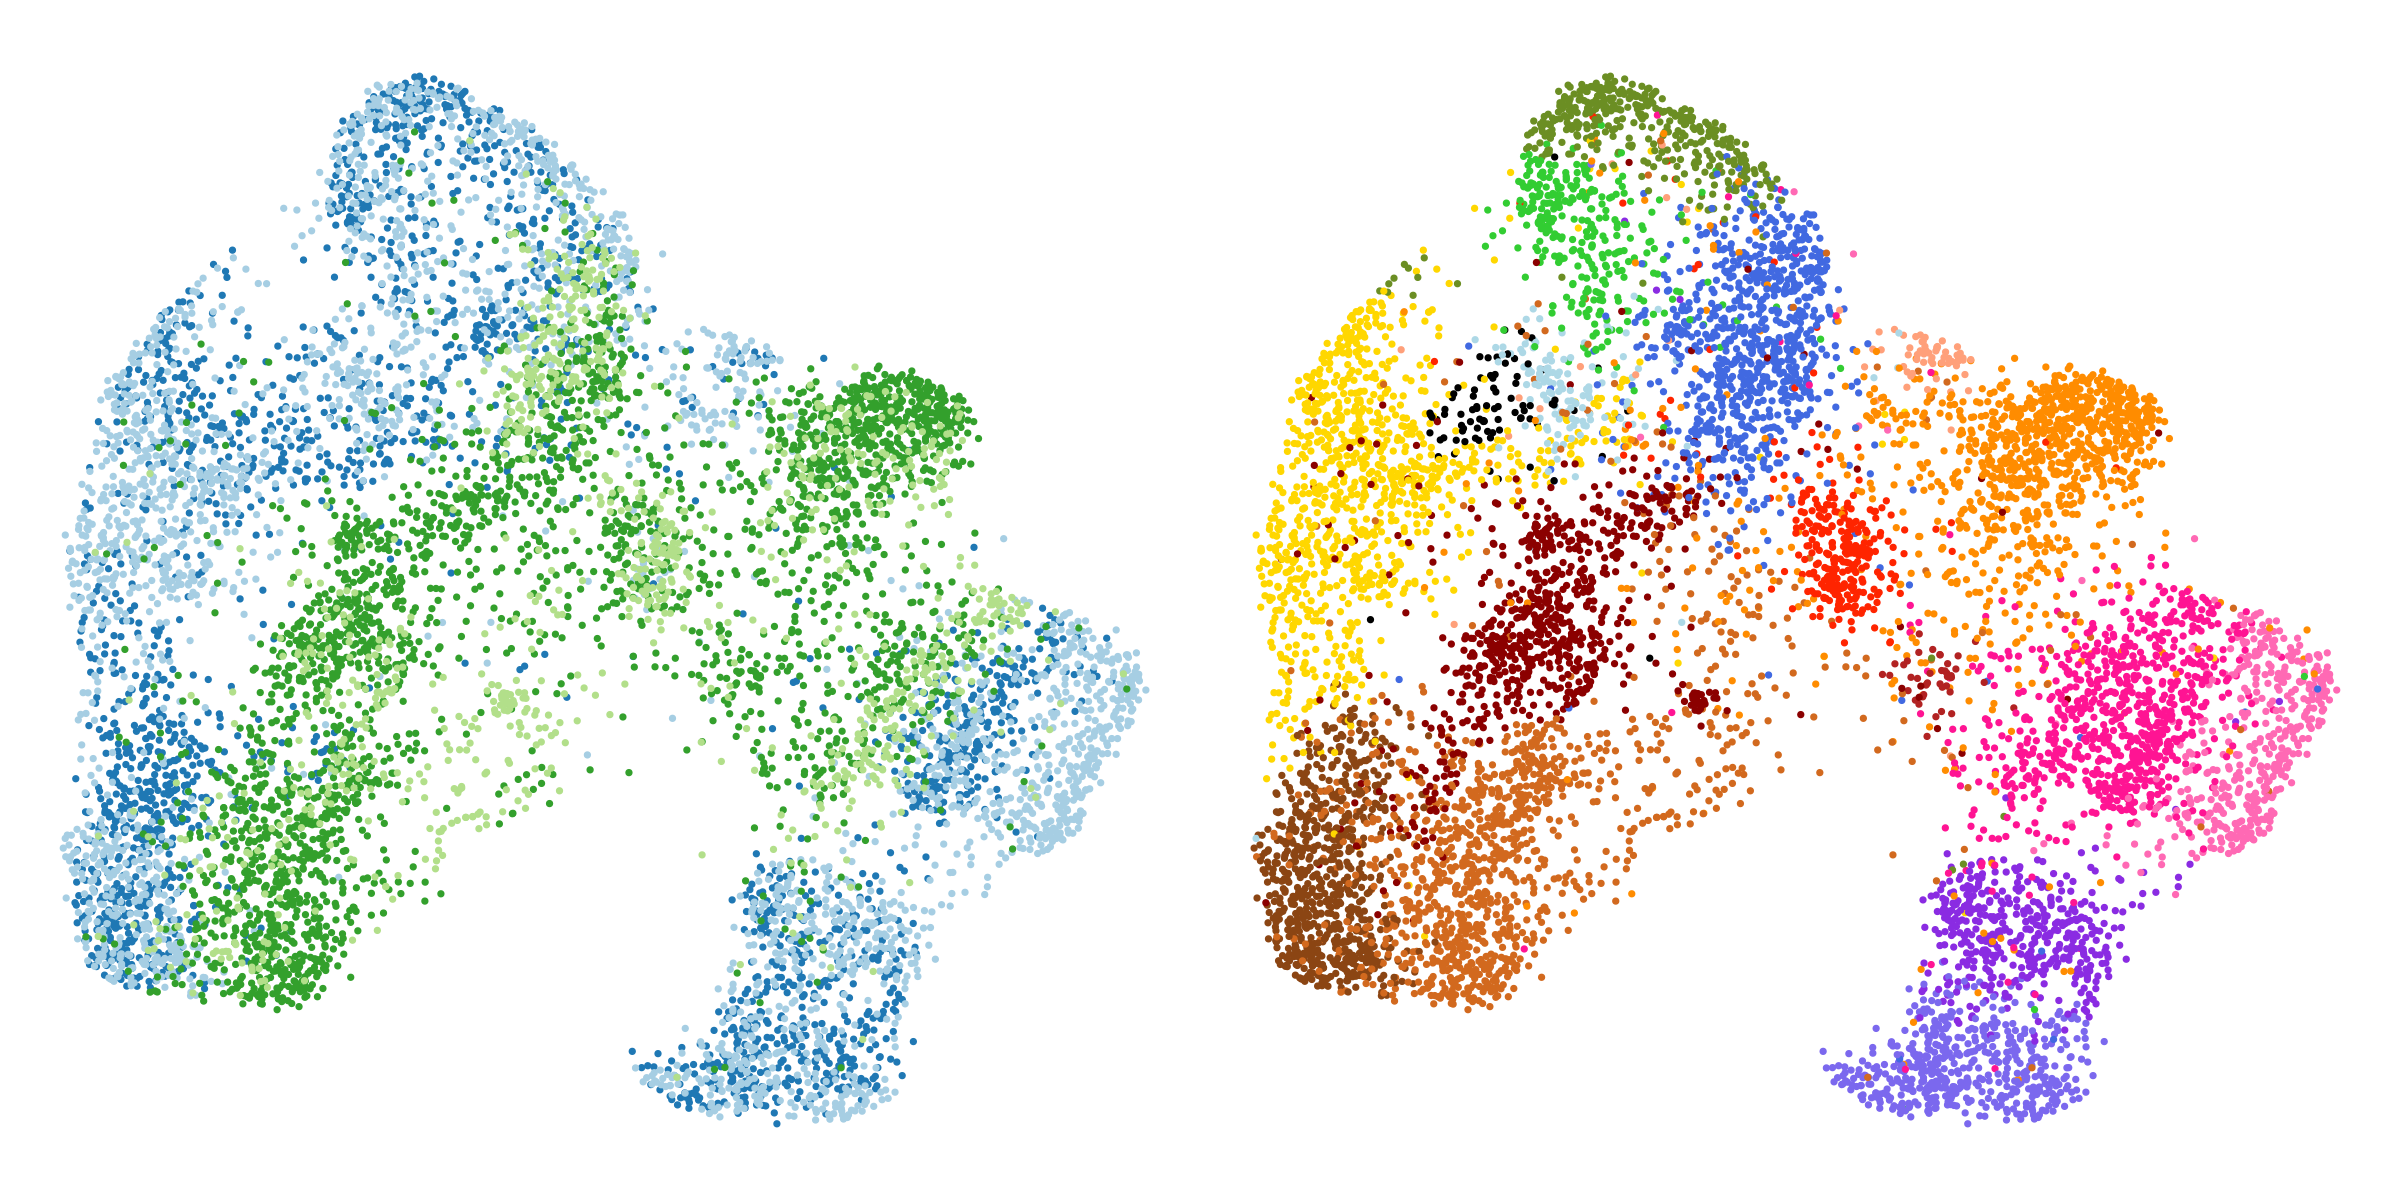

In [18]:
options(repr.plot.width=20, repr.plot.height=10)
width <- 5
height <- 5
pt_size <- 1

object <- seqFISH_postQC

p1 <- DimPlot(object, 
        reduction = "seqFISH_postQC_UMAP",
        group.by = "embryo",
        order = TRUE,
        pt.size = pt_size) +
        ggtitle(NULL) +
  theme_void() +
  coord_fixed() +
  scale_color_manual(values = embryo_colors) +
 theme(text = element_text(family = "Helvetica", size = 12),  # Set font family and size
        legend.position = "none")  # Make all axis lines black

p2 <- DimPlot(object, 
        reduction = "seqFISH_postQC_UMAP",
        group.by = "seqFISH_celltype_updated_2",
        order = FALSE,
        #label = TRUE,
        #label.size = 10,
        pt.size = pt_size) +
  ggtitle(NULL) +
  theme_void() +
  coord_fixed() +
  scale_color_manual(values = Harland_seqFISH_early) +
 theme(text = element_text(family = "Helvetica", size = 12),  # Set font family and size
        legend.position = "none")  # Make all axis lines black

p1 | p2

png 
  2

Plot saved to projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/fig_1/output/UMAP_combined_plot.pdf

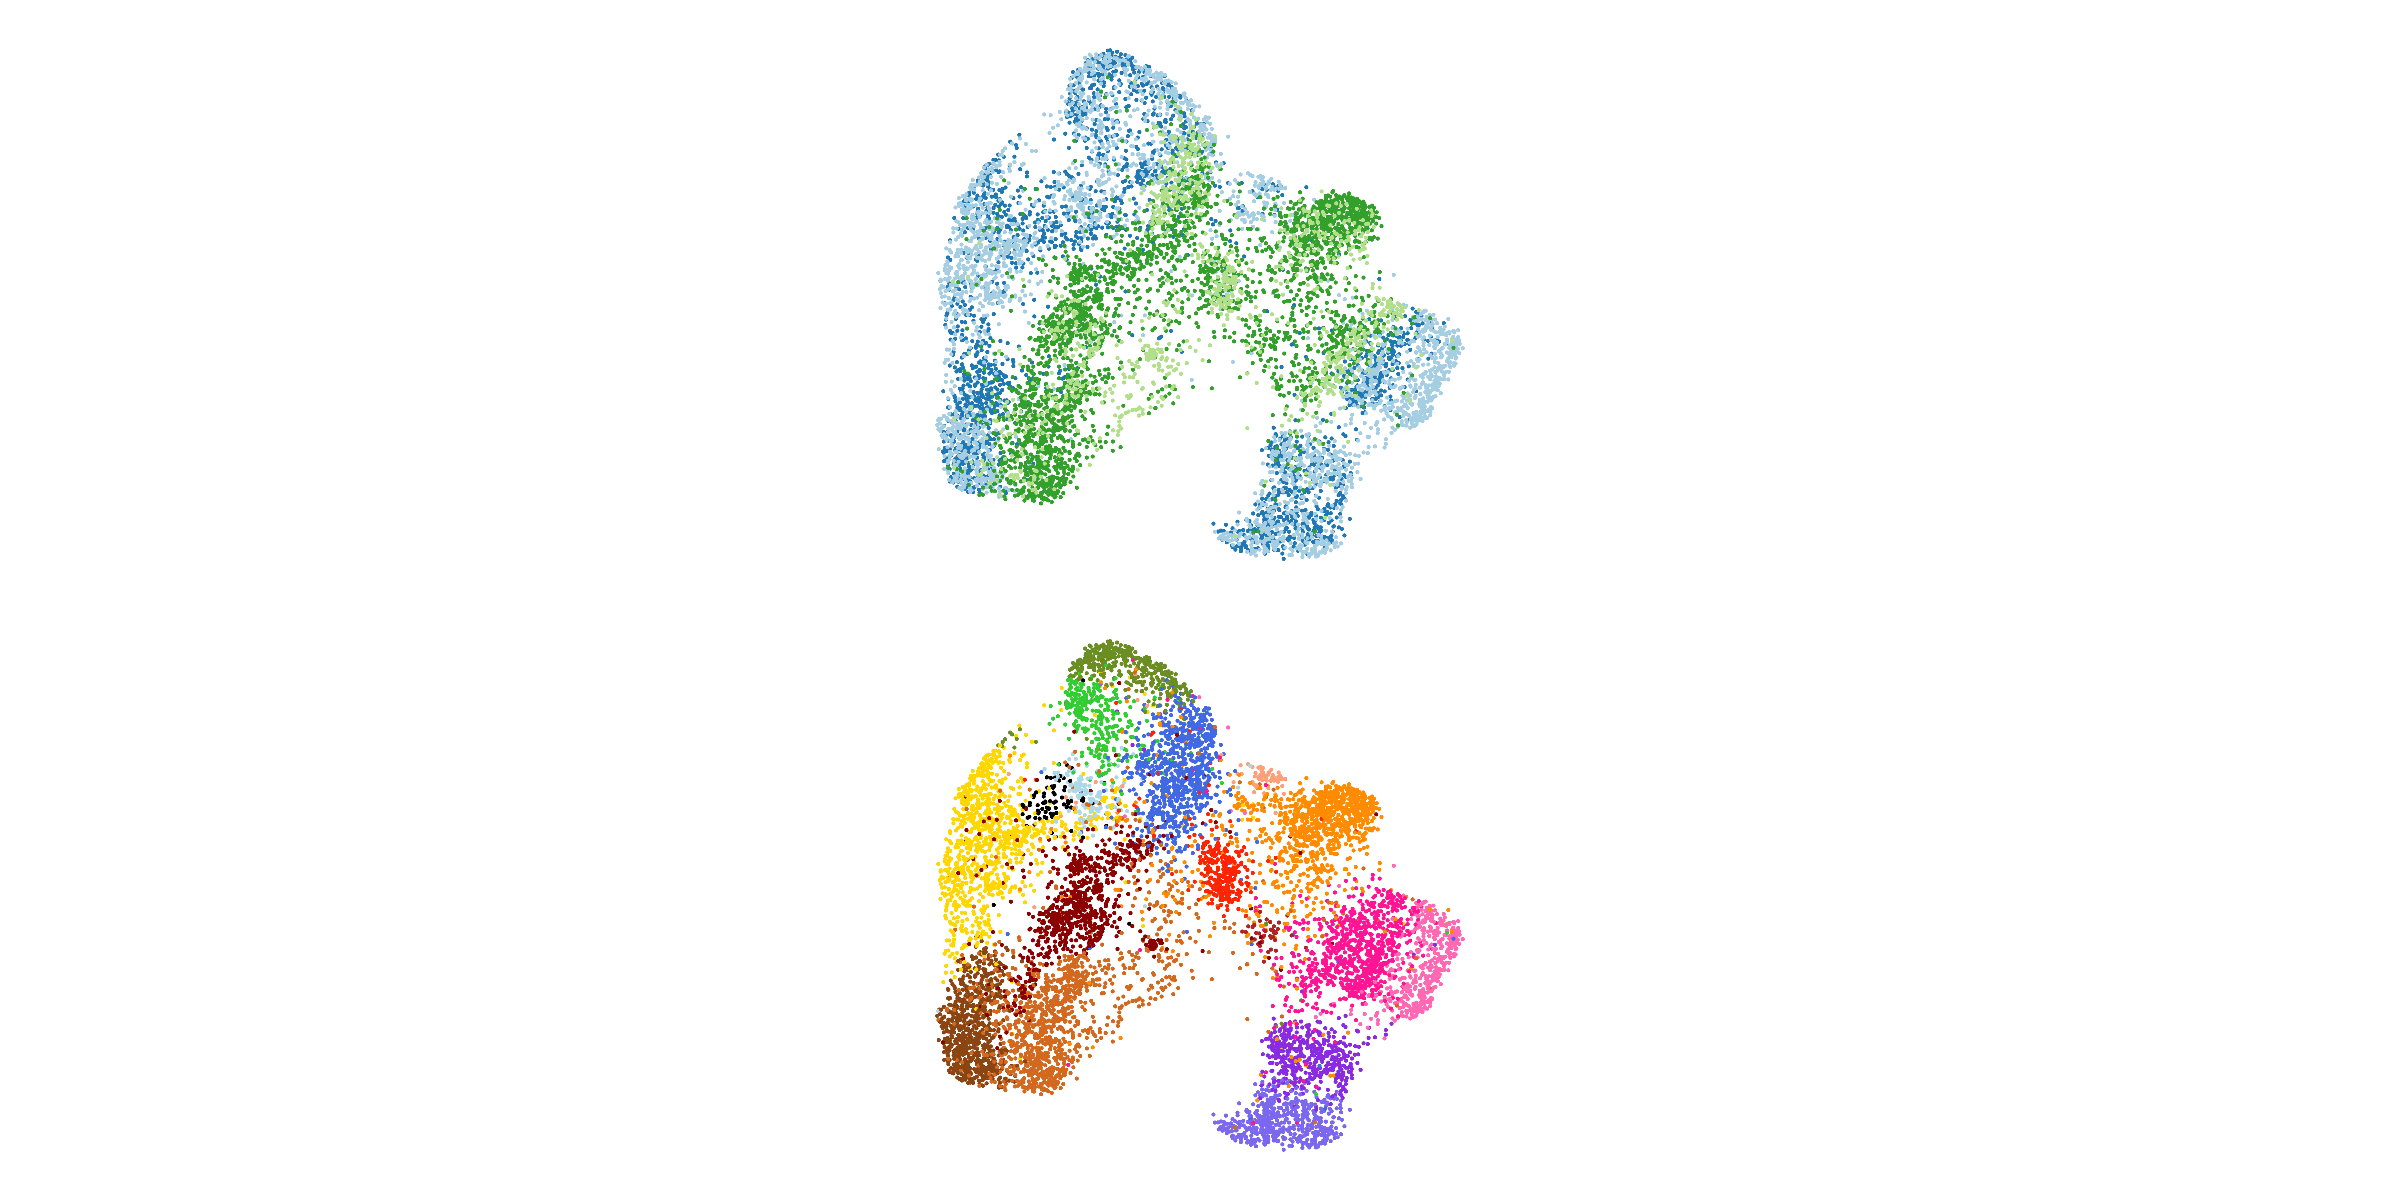

In [19]:
# Function to rasterize specific plots
rasterize_plot <- function(plot, dpi = 300) {
  temp_file <- tempfile(fileext = ".png")
  png(filename = temp_file, width = 7, height = 7, units = "in", res = dpi)
  print(plot)
  dev.off()
  img <- readPNG(temp_file)
  rasterGrob(img)
}

# Create plots
p1_raster <- rasterize_plot(p1)
p2_raster <- rasterize_plot(p2)
#p4_raster <- rasterize_plot(p4)
#p5_raster <- rasterize_plot(p5)
#p7_raster <- rasterize_plot(p7)
#p8_raster <- rasterize_plot(p8)

# Wrapping rasterized plots in a ggplot
p1 <- ggplot() + annotation_custom(p1_raster) + theme_void()
p2 <- ggplot() + annotation_custom(p2_raster) + theme_void()
#p4 <- ggplot() + annotation_custom(p4_raster) + theme_void()
#p5 <- ggplot() + annotation_custom(p5_raster) + theme_void()
#p7 <- ggplot() + annotation_custom(p7_raster) + theme_void()
#p8 <- ggplot() + annotation_custom(p8_raster) + theme_void()

# Create spacers
spacer <- plot_spacer()

# Combine plots using wrap_plots and adjust layout
combined_plot <- wrap_plots(
  p1, p2,
  #p10, p11, p12, spacer,
  ncol = 1, nrow = 2) +
  plot_layout(
    widths = c(1, 1),
    heights = c(1)
  )

# Specify the file path where you want to save the PDF file
file_path <- "projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/fig_1/output/UMAP_combined_plot.pdf"

# Save the combined plot as a PDF file with rasterized subplots
Cairo::CairoPDF(file = file_path, width = 150/4, height = 200/4)
print(combined_plot)
dev.off()

# Print a message to confirm the plot has been saved
cat("Plot saved to", file_path)

In [20]:
options(repr.plot.width=20, repr.plot.height=10)
width <- 5
height <- 5
pt_size <- 1

object <- seqFISH_preQC[,seqFISH_preQC@meta.data$embryo %in% "embryo_1"]

p1 <- DimPlot(object, 
        reduction = "spatial",
        group.by = "seqFISH_celltype_updated_2",
        order = TRUE,
        #label = TRUE,
        #label.size = 10,
        pt.size = pt_size) +
  ggtitle(NULL) +
  theme_void() +
  coord_fixed() +
  scale_color_manual(values = Harland_seqFISH_early) +
 theme(text = element_text(family = "Helvetica", size = 12),  # Set font family and size
        legend.position = "none")  # Make all axis lines black

object <- seqFISH_preQC[,seqFISH_preQC@meta.data$embryo %in% "embryo_2"]

p2 <- DimPlot(object, 
        reduction = "spatial",
        group.by = "seqFISH_celltype_updated_2",
        order = TRUE,
        #label = TRUE,
        #label.size = 10,
        pt.size = pt_size) +
  ggtitle(NULL) +
  theme_void() +
  coord_fixed() +
  scale_color_manual(values = Harland_seqFISH_early) +
 theme(text = element_text(family = "Helvetica", size = 12),  # Set font family and size
        legend.position = "none")  # Make all axis lines black

object <- seqFISH_preQC[,seqFISH_preQC@meta.data$embryo %in% "embryo_3"]

p3 <- DimPlot(object, 
        reduction = "spatial",
        group.by = "seqFISH_celltype_updated_2",
        order = TRUE,
        #label = TRUE,
        #label.size = 10,
        pt.size = pt_size) +
  ggtitle(NULL) +
  theme_void() +
  coord_fixed() +
  scale_color_manual(values = Harland_seqFISH_early) +
 theme(text = element_text(family = "Helvetica", size = 12),  # Set font family and size
        legend.position = "none")  # Make all axis lines black

object <- seqFISH_preQC[,seqFISH_preQC@meta.data$embryo %in% "embryo_4"]

p4 <- DimPlot(object, 
        reduction = "spatial",
        group.by = "seqFISH_celltype_updated_2",
        order = TRUE,
        #label = TRUE,
        #label.size = 10,
        pt.size = pt_size) +
  ggtitle(NULL) +
  theme_void() +
  coord_fixed() +
  scale_color_manual(values = Harland_seqFISH_early) +
 theme(text = element_text(family = "Helvetica", size = 12),  # Set font family and size
        legend.position = "none")  # Make all axis lines black

png 
  2

Plot saved to projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/fig_1/output/spatial_combined_plot.pdf

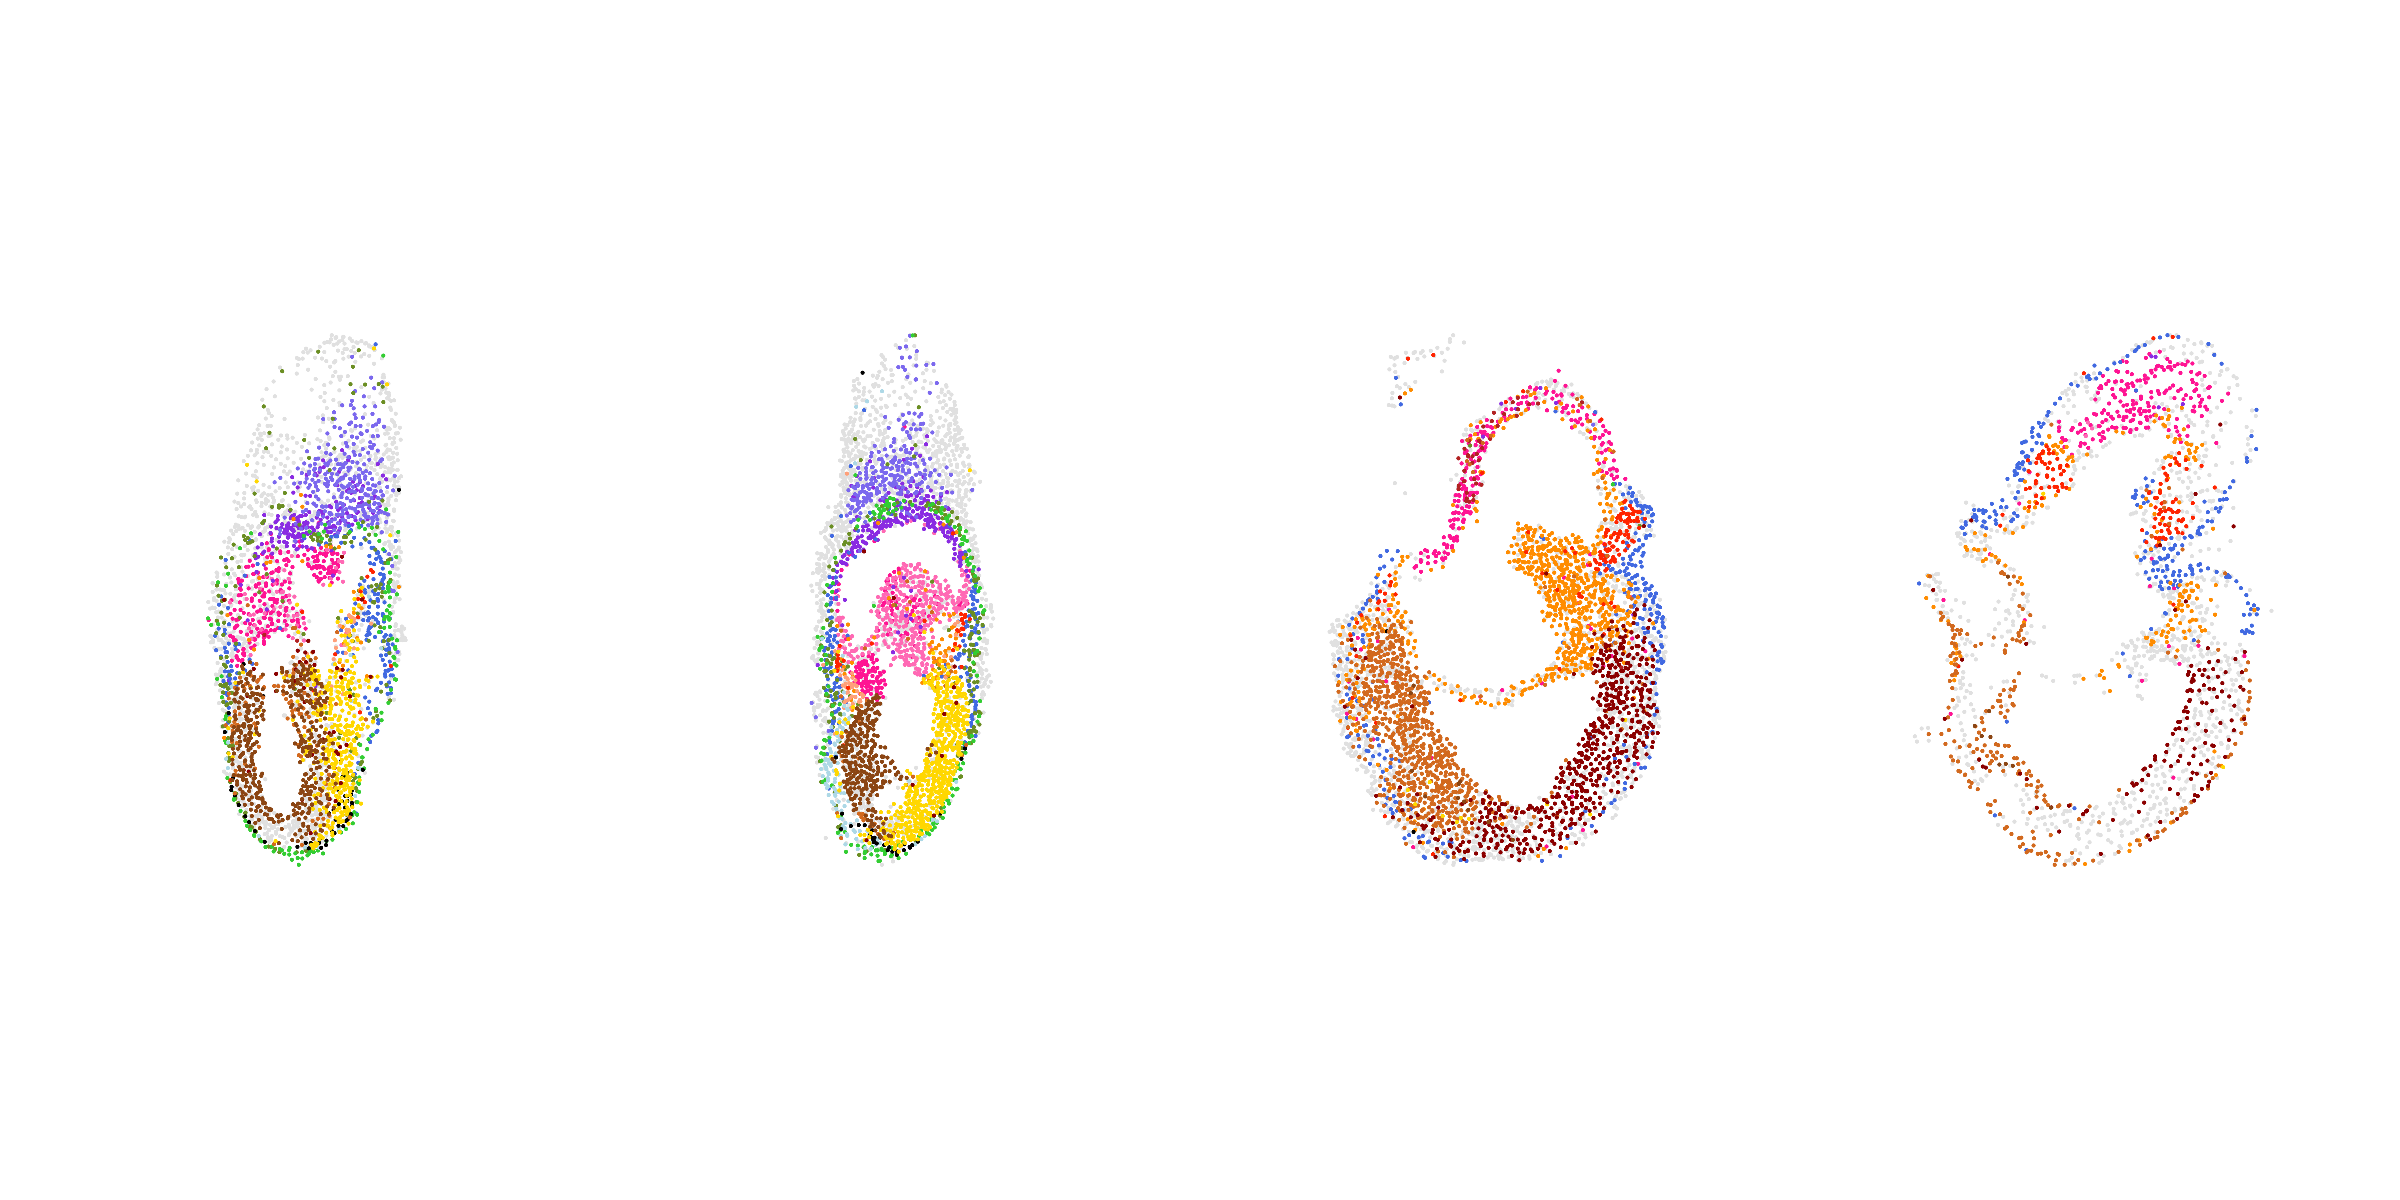

In [21]:
# Function to rasterize specific plots
rasterize_plot <- function(plot, dpi = 300) {
  temp_file <- tempfile(fileext = ".png")
  png(filename = temp_file, width = 7, height = 7, units = "in", res = dpi)
  print(plot)
  dev.off()
  img <- readPNG(temp_file)
  rasterGrob(img)
}

# Create plots
p1_raster <- rasterize_plot(p1)
p2_raster <- rasterize_plot(p2)
p3_raster <- rasterize_plot(p3)
p4_raster <- rasterize_plot(p4)
#p7_raster <- rasterize_plot(p7)
#p8_raster <- rasterize_plot(p8)

# Wrapping rasterized plots in a ggplot
p1 <- ggplot() + annotation_custom(p1_raster) + theme_void()
p2 <- ggplot() + annotation_custom(p2_raster) + theme_void()
p3 <- ggplot() + annotation_custom(p3_raster) + theme_void()
p4 <- ggplot() + annotation_custom(p4_raster) + theme_void()
#p7 <- ggplot() + annotation_custom(p7_raster) + theme_void()
#p8 <- ggplot() + annotation_custom(p8_raster) + theme_void()

# Create spacers
spacer <- plot_spacer()

# Combine plots using wrap_plots and adjust layout
combined_plot <- wrap_plots(
  p1, p2, p3, p4,
  #p10, p11, p12, spacer,
  ncol = 4, nrow = 1) +
  plot_layout(
    widths = c(1, 1, 1),
    heights = c(1)
  )

# Specify the file path where you want to save the PDF file
file_path <- "projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/fig_1/output/spatial_combined_plot.pdf"

# Save the combined plot as a PDF file with rasterized subplots
Cairo::CairoPDF(file = file_path, width = 150/4, height = 200/4)
print(combined_plot)
dev.off()

# Print a message to confirm the plot has been saved
cat("Plot saved to", file_path)

png 
  2

Plot saved to projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/fig_1/output/proportional_plot.pdf

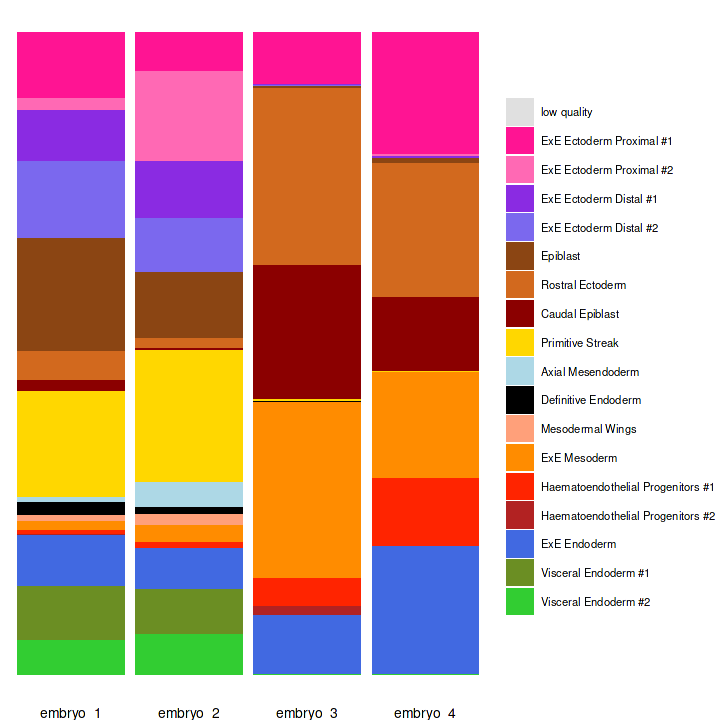

In [22]:
options(repr.plot.width=5, repr.plot.height=6)

object <- seqFISH_postQC

# Create the table of cell counts
cell_counts <- table(object@meta.data$seqFISH_celltype_updated_2, object@meta.data$embryo)

# Compute proportions within each embryo
proportions <- apply(cell_counts, 2, function(x) x/sum(x))

# Convert the proportions matrix to a data frame
proportions_df <- as.data.frame(proportions)

# Add a column for cell types (rownames become a column)
proportions_df$CellType <- rownames(proportions_df)

# Melt the data frame to long format (tidy format) for ggplot2
proportions_melted <- melt(proportions_df, id.vars = "CellType", variable.name = "Embryo", value.name = "Proportion")
                     
options(repr.plot.width=6, repr.plot.height=6)
width <- 6
height <- 6

# order the cell types 
proportions_melted$CellType <- factor(proportions_melted$CellType, 
                                                      levels = Harland_seqFISH_early_order)
                     
# Create the stacked bar chart
p1 <- ggplot(proportions_melted, aes(x = Embryo, y = Proportion, fill = CellType)) +
  geom_bar(stat = "identity") +
  labs(title = "Proportion of Cell Types in Each Embryo",
       x = "Embryo",
       y = NULL,
       fill = NULL) +
    ggtitle(NULL)+
  theme_void() +
        theme(text = element_text(family = "Arial", size = 8),  # Set font family and size
        legend.position = "right",
        axis.line = element_blank(), # Make all axis lines black
        axis.title.x = element_blank(),  # Ensure x-axis title is blank
        axis.title.y = element_blank(), # Ensure y-axis title is blank)  
        axis.text.x = element_text(angle = 0, hjust = 0.5),
        axis.text.y = element_blank())    +
  scale_fill_manual(values = Harland_seqFISH_early)

# Specify the file path where you want to save the PDF file
file_path <- "projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/fig_1/output/proportional_plot.pdf"

# Save the combined plot as a PDF file with rasterized subplots
Cairo::CairoPDF(file = file_path, width = 150/8, height = 200/8)
print(p1)
dev.off()

# Print a message to confirm the plot has been saved
cat("Plot saved to", file_path)

Calculating cluster ExE Ectoderm Proximal #1

Calculating cluster ExE Ectoderm Proximal #2

Calculating cluster ExE Ectoderm Distal #1

Calculating cluster ExE Ectoderm Distal #2

Calculating cluster Epiblast

Calculating cluster Rostral Ectoderm

Calculating cluster Caudal Epiblast

Calculating cluster Primitive Streak

Calculating cluster Axial Mesendoderm

Calculating cluster Definitive Endoderm

Calculating cluster Mesodermal Wings

Calculating cluster ExE Mesoderm

Calculating cluster Haematoendothelial Progenitors #1

Calculating cluster Haematoendothelial Progenitors #2

Calculating cluster ExE Endoderm

Calculating cluster Visceral Endoderm #1

Calculating cluster Visceral Endoderm #2

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


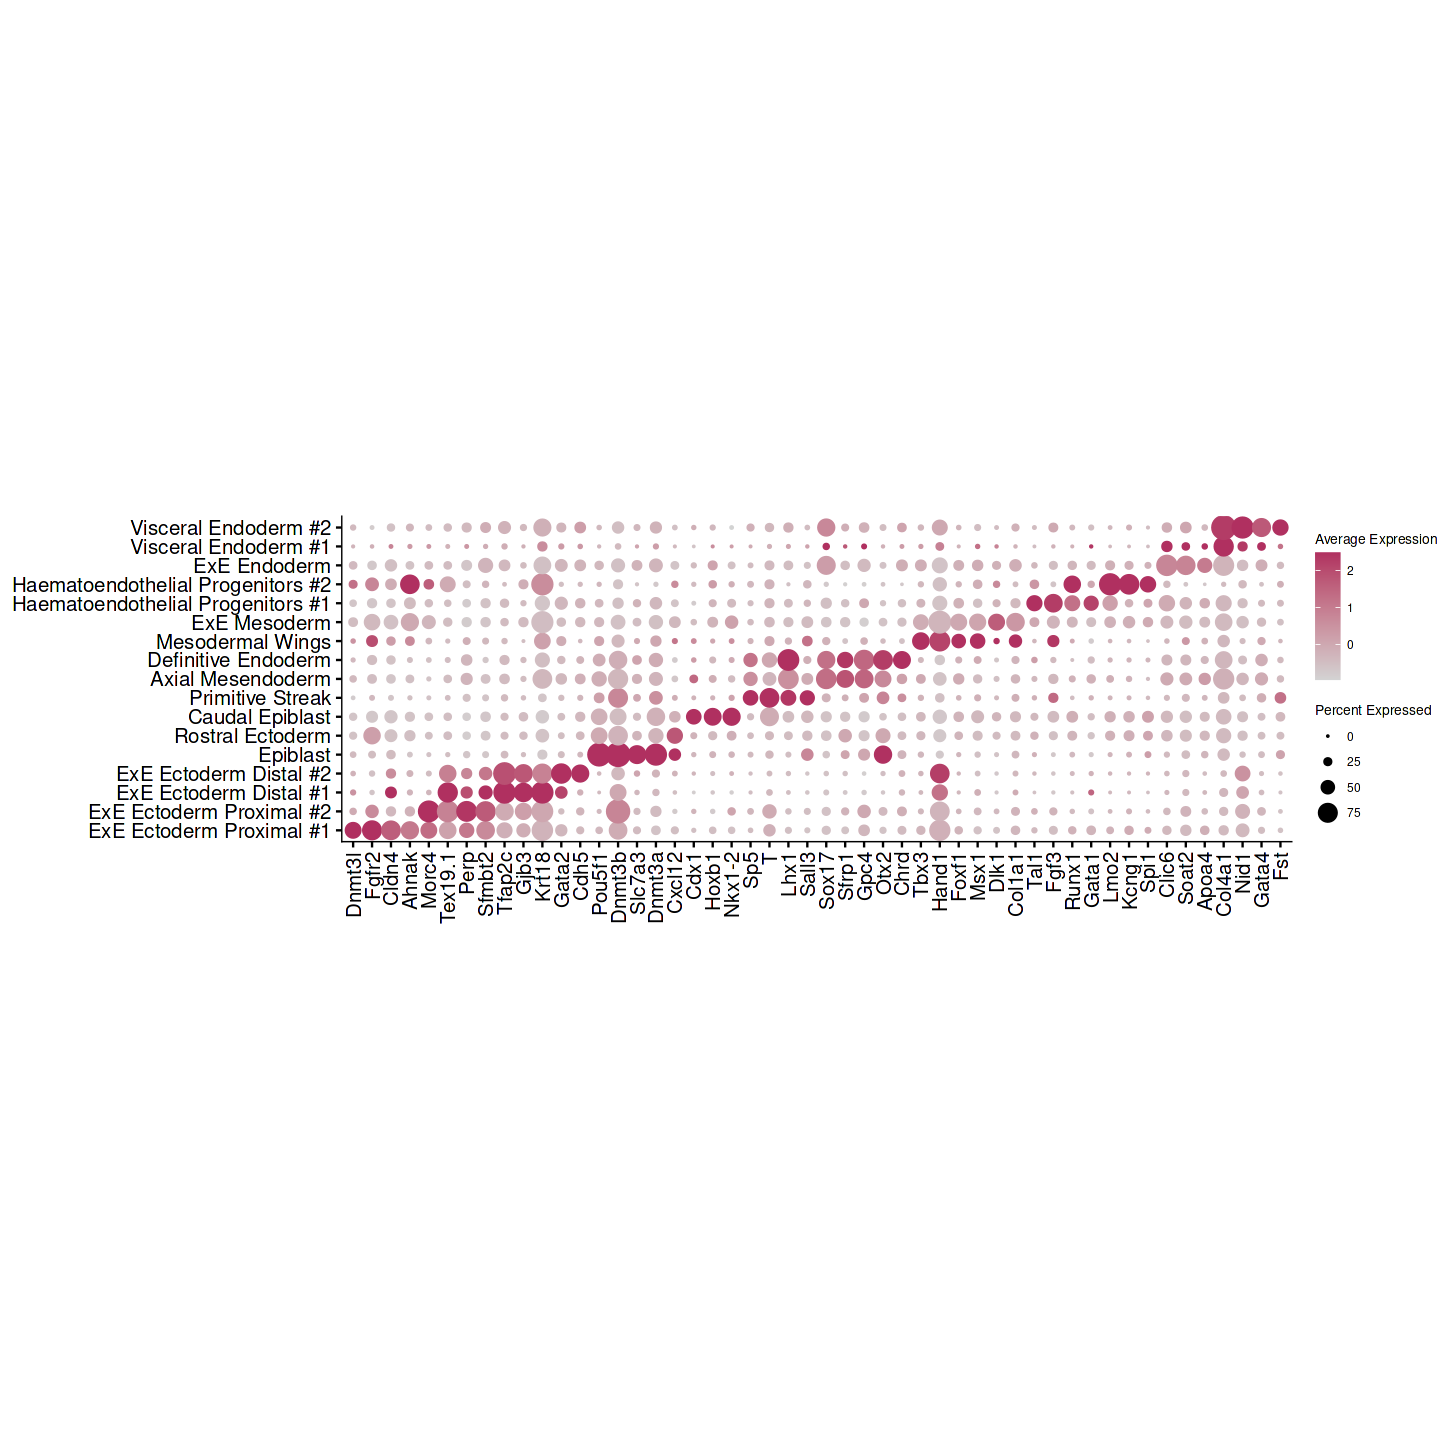

In [23]:
##Order the cell types
seqFISH_postQC$seqFISH_celltype_updated_2 <- factor(seqFISH_postQC$seqFISH_celltype_updated_2, 
                                                      levels = Harland_seqFISH_early_order)

object <- seqFISH_postQC
Idents(object) <- "seqFISH_celltype_updated_2"
DefaultAssay(object) <- "originalexp"

# Identify all markers
markers <- FindAllMarkers(
    object,
    assay = "originalexp",
    features = rownames(object),  # Use only variable features
    slot = "data",
    min.pct = 0.1,  # Filter lowly expressed genes
    only.pos = TRUE  # Consider only positive markers
)

markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > log2(1.5)) %>%
    slice_head(n = 4) %>%
    ungroup() -> top_markers

options(repr.plot.width=6*2, repr.plot.height=6*2)
width <- 6*2
height <- 6*2.2

p2 <- DotPlot(object = object, 
        features = unique(c(top_markers$gene)),
        cols = c("lightgrey", "maroon"),
        dot.min = 0) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        coord_fixed() +
        theme(text = element_text(family = "Arial", size = 8),  # Set font family and size
        legend.position = "right",
        axis.line = element_line(color = "black",  size = 0.3), # Make all axis lines black
        axis.title.x = element_blank(),  # Ensure x-axis title is blank
        axis.title.y = element_blank(), # Ensure y-axis title is blank)  
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
        axis.text.y = element_text(angle = 0, hjust = 1))   

# Save the grid plot as .svg file to specific file path
ggsave(filename = "projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/fig_1/output/marker_genes_clusters_E6_E7.svg", plot = p2, device = "svg",
      width = width,
      height = height)

p2

In [24]:
options(repr.plot.width=20, repr.plot.height=10)
width <- 5
height <- 5
pt_size <- 1

object <- seqFISH_preQC[,seqFISH_preQC@meta.data$embryo %in% "embryo_2"]
DefaultAssay(object) <- "originalexp"

p1 <- FeaturePlot(object, 
        reduction = "spatial",
        feature = "Dnmt3b",
        order = TRUE,
        #label = TRUE,
        #label.size = 10,
        pt.size = pt_size) +
  ggtitle(NULL) +
  theme_void() +
  coord_fixed() +
 theme(text = element_text(family = "Helvetica", size = 12),  # Set font family and size
        legend.position = "none")  # Make all axis lines black

p2 <- FeaturePlot(object, 
        reduction = "spatial",
        feature = "Pou5f1",
        order = TRUE,
        #label = TRUE,
        #label.size = 10,
        pt.size = pt_size) +
  ggtitle(NULL) +
  theme_void() +
  coord_fixed() +
 theme(text = element_text(family = "Helvetica", size = 12),  # Set font family and size
        legend.position = "none")  # Make all axis lines black

p3 <- FeaturePlot(object, 
        reduction = "spatial",
        feature = "T",
        order = TRUE,
        #label = TRUE,
        #label.size = 10,
        pt.size = pt_size) +
  ggtitle(NULL) +
  theme_void() +
  coord_fixed() +
 theme(text = element_text(family = "Helvetica", size = 12),  # Set font family and size
        legend.position = "none")  # Make all axis lines black

p4 <- FeaturePlot(object, 
        reduction = "spatial",
        feature = "Clic6",
        order = TRUE,
        #label = TRUE,
        #label.size = 10,
        pt.size = pt_size) +
  ggtitle(NULL) +
  theme_void() +
  coord_fixed() +
 theme(text = element_text(family = "Helvetica", size = 12),  # Set font family and size
        legend.position = "none")  # Make all axis lines black

p5 <- FeaturePlot(object, 
        reduction = "spatial",
        feature = "Cdx2",
        order = TRUE,
        #label = TRUE,
        #label.size = 10,
        pt.size = pt_size) +
  ggtitle(NULL) +
  theme_void() +
  coord_fixed() +
 theme(text = element_text(family = "Helvetica", size = 12),  # Set font family and size
        legend.position = "none")  # Make all axis lines black

png 
  2

Plot saved to projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/fig_1/output/embryo_2_features.pdf

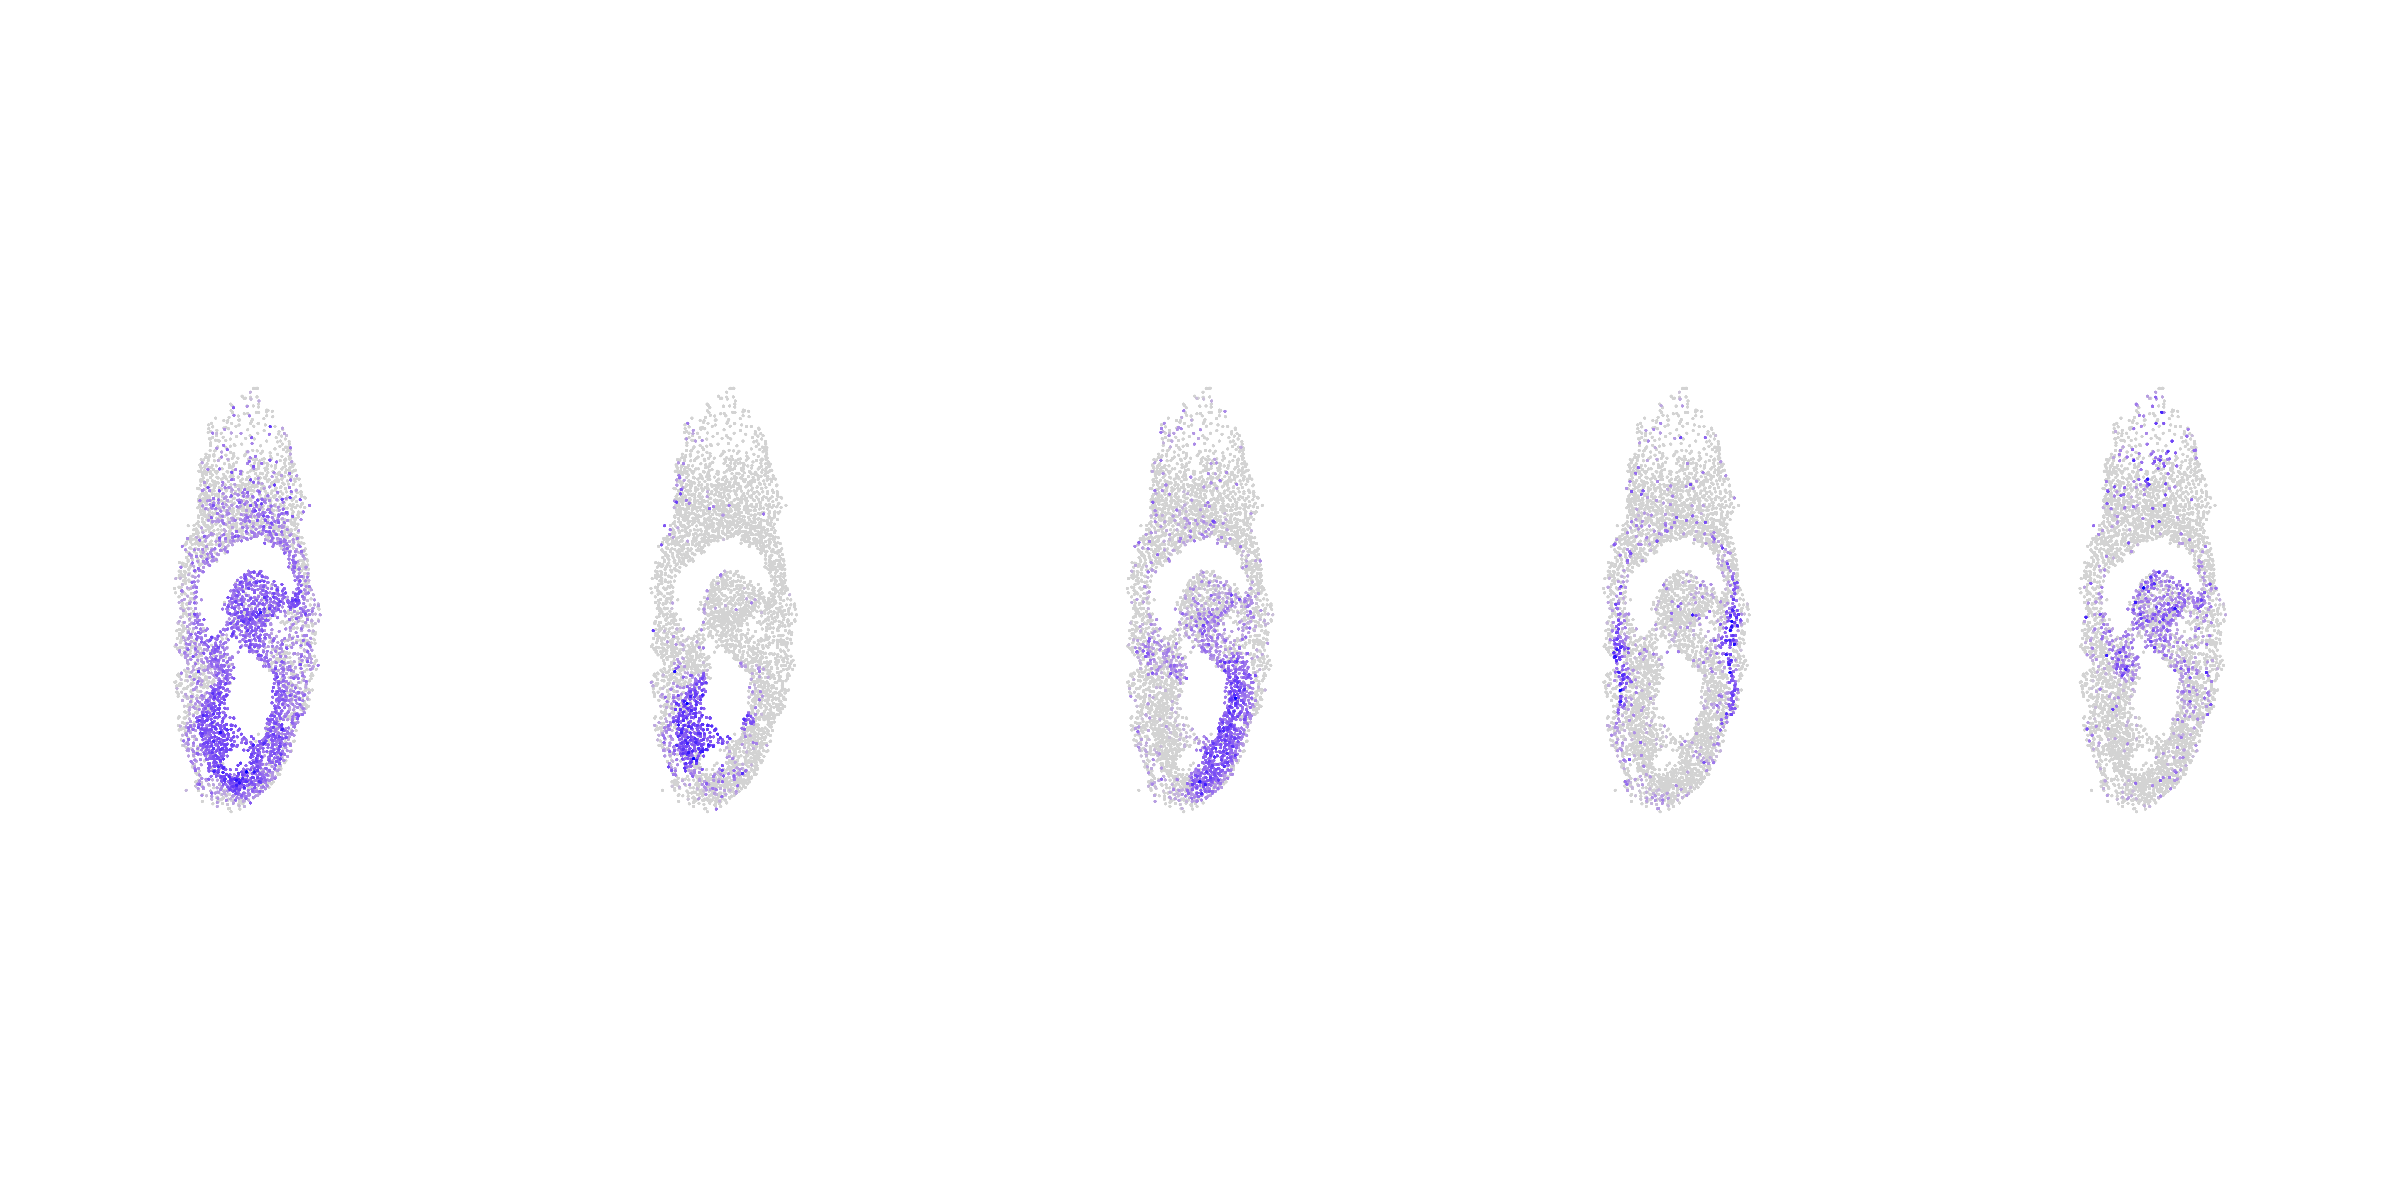

In [25]:
# Function to rasterize specific plots
rasterize_plot <- function(plot, dpi = 300) {
  temp_file <- tempfile(fileext = ".png")
  png(filename = temp_file, width = 7, height = 7, units = "in", res = dpi)
  print(plot)
  dev.off()
  img <- readPNG(temp_file)
  rasterGrob(img)
}

# Create plots
p1_raster <- rasterize_plot(p1)
p2_raster <- rasterize_plot(p2)
p3_raster <- rasterize_plot(p3)
p4_raster <- rasterize_plot(p4)
p5_raster <- rasterize_plot(p5)
#p8_raster <- rasterize_plot(p8)

# Wrapping rasterized plots in a ggplot
p1 <- ggplot() + annotation_custom(p1_raster) + theme_void()
p2 <- ggplot() + annotation_custom(p2_raster) + theme_void()
p3 <- ggplot() + annotation_custom(p3_raster) + theme_void()
p4 <- ggplot() + annotation_custom(p4_raster) + theme_void()
p5 <- ggplot() + annotation_custom(p5_raster) + theme_void()
#p8 <- ggplot() + annotation_custom(p8_raster) + theme_void()

# Create spacers
spacer <- plot_spacer()

# Combine plots using wrap_plots and adjust layout
combined_plot <- wrap_plots(
  p1, p2, p3, p4, p5,
  #p10, p11, p12, spacer,
  ncol = 5, nrow = 1) +
  plot_layout(
    widths = c(1, 1, 1, 1, 1),
    heights = c(1)
  )

# Specify the file path where you want to save the PDF file
file_path <- "projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/fig_1/output/embryo_2_features.pdf"

# Save the combined plot as a PDF file with rasterized subplots
Cairo::CairoPDF(file = file_path, width = 150/4, height = 200/4)
print(combined_plot)
dev.off()

# Print a message to confirm the plot has been saved
cat("Plot saved to", file_path)

In [26]:
options(repr.plot.width=20, repr.plot.height=10)
width <- 5
height <- 5
pt_size <- 1

object <- seqFISH_preQC[,seqFISH_preQC@meta.data$embryo %in% "embryo_3"]
DefaultAssay(object) <- "originalexp"

p1 <- FeaturePlot(object, 
        reduction = "spatial",
        feature = "T",
        order = TRUE,
        #label = TRUE,
        #label.size = 10,
        pt.size = pt_size) +
  ggtitle(NULL) +
  theme_void() +
  coord_fixed() +
 theme(text = element_text(family = "Helvetica", size = 12),  # Set font family and size
        legend.position = "none")  # Make all axis lines black

p2 <- FeaturePlot(object, 
        reduction = "spatial",
        feature = "Tbx4",
        order = TRUE,
        #label = TRUE,
        #label.size = 10,
        pt.size = pt_size) +
  ggtitle(NULL) +
  theme_void() +
  coord_fixed() +
 theme(text = element_text(family = "Helvetica", size = 12),  # Set font family and size
        legend.position = "none")  # Make all axis lines black

p3 <- FeaturePlot(object, 
        reduction = "spatial",
        feature = "Otx2",
        order = TRUE,
        #label = TRUE,
        #label.size = 10,
        pt.size = pt_size) +
  ggtitle(NULL) +
  theme_void() +
  coord_fixed() +
 theme(text = element_text(family = "Helvetica", size = 12),  # Set font family and size
        legend.position = "none")  # Make all axis lines black

p4 <- FeaturePlot(object, 
        reduction = "spatial",
        feature = "Nkx1-2",
        order = TRUE,
        #label = TRUE,
        #label.size = 10,
        pt.size = pt_size) +
  ggtitle(NULL) +
  theme_void() +
  coord_fixed() +
 theme(text = element_text(family = "Helvetica", size = 12),  # Set font family and size
        legend.position = "none")  # Make all axis lines black

p5 <- FeaturePlot(object, 
        reduction = "spatial",
        feature = "Fgf3",
        order = TRUE,
        #label = TRUE,
        #label.size = 10,
        pt.size = pt_size) +
  ggtitle(NULL) +
  theme_void() +
  coord_fixed() +
 theme(text = element_text(family = "Helvetica", size = 12),  # Set font family and size
        legend.position = "none")  # Make all axis lines black

png 
  2

Plot saved to projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/fig_1/output/embryo_3_features.pdf

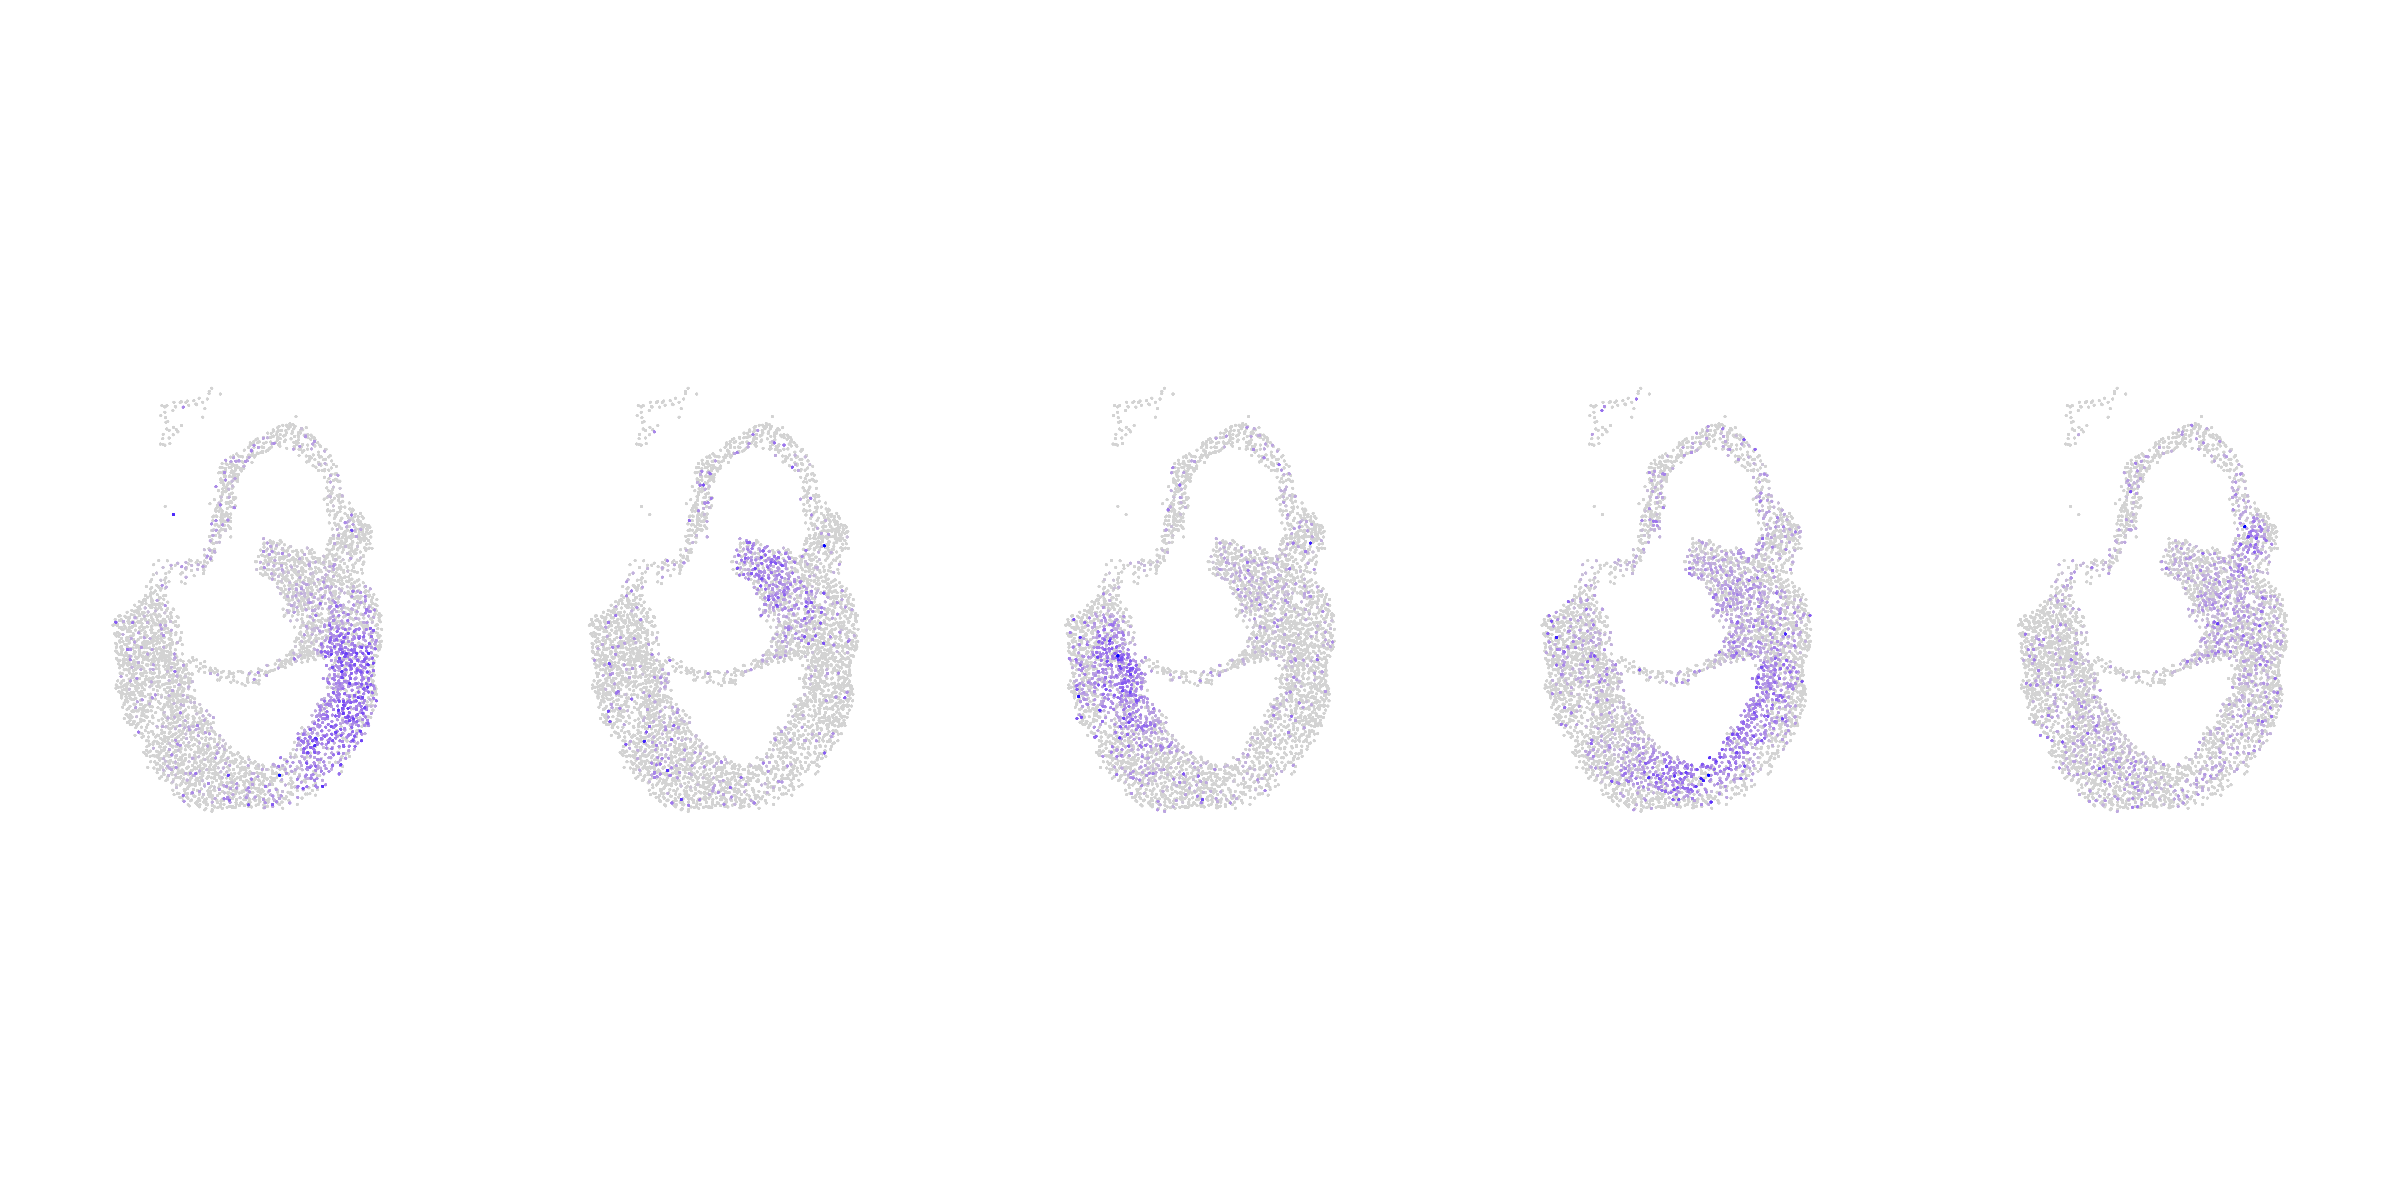

In [27]:
# Function to rasterize specific plots
rasterize_plot <- function(plot, dpi = 300) {
  temp_file <- tempfile(fileext = ".png")
  png(filename = temp_file, width = 7, height = 7, units = "in", res = dpi)
  print(plot)
  dev.off()
  img <- readPNG(temp_file)
  rasterGrob(img)
}

# Create plots
p1_raster <- rasterize_plot(p1)
p2_raster <- rasterize_plot(p2)
p3_raster <- rasterize_plot(p3)
p4_raster <- rasterize_plot(p4)
p5_raster <- rasterize_plot(p5)
#p8_raster <- rasterize_plot(p8)

# Wrapping rasterized plots in a ggplot
p1 <- ggplot() + annotation_custom(p1_raster) + theme_void()
p2 <- ggplot() + annotation_custom(p2_raster) + theme_void()
p3 <- ggplot() + annotation_custom(p3_raster) + theme_void()
p4 <- ggplot() + annotation_custom(p4_raster) + theme_void()
p5 <- ggplot() + annotation_custom(p5_raster) + theme_void()
#p8 <- ggplot() + annotation_custom(p8_raster) + theme_void()

# Create spacers
spacer <- plot_spacer()

# Combine plots using wrap_plots and adjust layout
combined_plot <- wrap_plots(
  p1, p2, p3, p4, p5,
  #p10, p11, p12, spacer,
  ncol = 5, nrow = 1) +
  plot_layout(
    widths = c(1, 1, 1, 1, 1),
    heights = c(1)
  )

# Specify the file path where you want to save the PDF file
file_path <- "projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/fig_1/output/embryo_3_features.pdf"

# Save the combined plot as a PDF file with rasterized subplots
Cairo::CairoPDF(file = file_path, width = 150/4, height = 200/4)
print(combined_plot)
dev.off()

# Print a message to confirm the plot has been saved
cat("Plot saved to", file_path)

## Generate Supp Figure 1

In [28]:
library(ggplot2)
library(gridExtra)
library(patchwork)
library(grid)
library(Cairo)
library(png)

# Function to rasterize specific plots
rasterize_plot <- function(plot, dpi = 300) {
  temp_file <- tempfile(fileext = ".png")
  png(filename = temp_file, width = 7, height = 7, units = "in", res = dpi)
  print(plot)
  dev.off()
  img <- readPNG(temp_file)
  rasterGrob(img)
}

# Define parameters
options(repr.plot.width = 20, repr.plot.height = 10)
pt_size <- 2

# Get unique embryos and ensure dim3_binarized values are sorted numerically
embryos <- unique(seqFISH_preQC@meta.data$embryo)
dim3_values <- sort(as.numeric(unique(seqFISH_preQC@meta.data$dim3_binarized)), na.last = TRUE)

# Loop through each embryo
for (embryo in embryos) {
  
  # **Determine xlim and ylim specific to this embryo**
  embryo_cells <- seqFISH_preQC[, seqFISH_preQC@meta.data$embryo %in% embryo]
  xlim_range <- range(embryo_cells@reductions$spatial@cell.embeddings[, 1], na.rm = TRUE)
  ylim_range <- range(embryo_cells@reductions$spatial@cell.embeddings[, 2], na.rm = TRUE)
  
  # Initialize an empty list to store rasterized plots
  rasterized_plots <- list()
  
  # Loop through each unique value of dim3_binarized in numerical order (1 to 5)
  for (dim3_value in dim3_values) {
    
    # Subset the object for the current embryo and dim3_binarized value
    object <- embryo_cells[, embryo_cells@meta.data$dim3_binarized %in% dim3_value]
    
    # Generate the plot with **fixed xlim and ylim for this embryo** and **NO TITLE**
    p <- DimPlot(object, 
                 reduction = "spatial",
                 group.by = "seqFISH_celltype_updated_2",
                 order = TRUE,
                 pt.size = pt_size) +
      theme_void() +  # Remove all axes and grid
      coord_fixed() +  # Maintain aspect ratio
      scale_color_manual(values = Harland_seqFISH_early) +
      xlim(xlim_range) +  # **Fix x-axis limits per embryo**
      ylim(ylim_range) +  # **Fix y-axis limits per embryo**
      theme(
        text = element_text(family = "Helvetica", size = 12),
        legend.position = "none",
        plot.title = element_blank()  # **Ensure title is removed**
      )
    
    # Rasterize the plot
    rasterized_plots[[as.character(dim3_value)]] <- rasterize_plot(p)
  }
  
  # Convert rasterized plots into ggplot objects
  raster_ggplots <- lapply(rasterized_plots, function(r) {
    ggplot() + annotation_custom(r) + theme_void()
  })
  
  # Arrange plots in a grid with **5 columns**, maintaining order (1 → 5)
  combined_plot <- wrap_plots(raster_ggplots, ncol = 5, nrow = ceiling(length(raster_ggplots) / 5)) +
    plot_layout(
      widths = rep(1, min(5, length(raster_ggplots))),
      heights = rep(1, ceiling(length(raster_ggplots) / 5))
    )
  
  # Specify the file path for each embryo
  file_path <- paste0("projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/fig_1/output/", embryo, "_binarized.pdf")
  
  # Save the combined plot as a PDF file with rasterized subplots
  Cairo::CairoPDF(file = file_path, width = 150/4, height = 200/4)
  print(combined_plot)
  dev.off()
  
  # Print a message to confirm the plot has been saved
  cat("Plot saved to", file_path, "\n")
}

Plot saved to projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/fig_1/output/embryo_1_binarized.pdf 
Plot saved to projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/fig_1/output/embryo_2_binarized.pdf 
Plot saved to projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/fig_1/output/embryo_3_binarized.pdf 
Plot saved to projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/fig_1/output/embryo_4_binarized.pdf 


## Save the Updated seqFISH Cell Type Annotations for the E6.5 and E7.5 embryos

In [29]:
# Your data.frame
my_data <- seqFISH_postQC@meta.data$seqFISH_celltype_updated_2

# Define output path
output_path <- "projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/fig_1/output/seqFISH_celltype_updated_2.rds"

# Save as .rds
saveRDS(my_data, file = output_path)

## Print out Package Versions

In [30]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] gridExtra_2.3               reshape2_1.4.4             
 [3] png_0.1-8                   Cairo_1.6-0                
 [5] viridis_0.6.2               viridisLite_0.4.1          
 [7] cowplot_1.1.1               ggpubr_0.4.0               
 [9] batchelor_1.12.3            pheatmap_1.0.12            
[11] plotly_4.10.0 